In [221]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [222]:
# Read the dataset
orders = pd.read_csv('../PizzaPlaceSales/pizza_sales/order_summary.csv')

In [223]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48592 entries, 0 to 48591
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   order_id          48592 non-null  int64  
 1   order_details_id  48592 non-null  int64  
 2   o_date            48592 non-null  object 
 3   o_time            48592 non-null  object 
 4   pizza_id          48592 non-null  object 
 5   quantity          48592 non-null  int64  
 6   pizza_type_id     48592 non-null  object 
 7   size              48592 non-null  object 
 8   unit_price        48592 non-null  float64
 9   name              48592 non-null  object 
 10  category          48592 non-null  object 
dtypes: float64(1), int64(3), object(7)
memory usage: 4.1+ MB


In [224]:
orders.describe()

,order_id,order_details_id,quantity,unit_price
count,48592.000000,48592.000000,48592.000000,48592.000000
mean,10701.841558,24311.322996,1.019633,16.482921
std,6180.167605,14035.645809,0.143117,3.592585
min,1.000000,1.000000,1.000000,9.750000
25%,5337.750000,12156.750000,1.000000,12.750000
50%,10685.000000,24313.500000,1.000000,16.500000
75%,16100.000000,36465.250000,1.000000,20.250000
max,21350.000000,48620.000000,4.000000,25.500000


In [225]:
# Convert o_date and o_time to proper DateTime columns. Drop original

orders["date"] = pd.to_datetime(orders["o_date"])
orders['hour'] = pd.to_datetime(orders['o_time'], format='%H:%M:%S').dt.hour
orders.drop(columns=['o_date','o_time'],inplace=True)

In [226]:
orders.head()

,order_id,order_details_id,pizza_id,quantity,pizza_type_id,size,unit_price,name,category,date,hour
0,9,23,veggie_veg_s,1,veggie_veg,S,12.00,The Vegetables + Vegetables Pizza,Veggie,2015-01-01,12
1,47,116,veggie_veg_s,1,veggie_veg,S,12.00,The Vegetables + Vegetables Pizza,Veggie,2015-01-01,18
2,7,13,spinach_supr_s,1,spinach_supr,S,12.50,The Spinach Supreme Pizza,Supreme,2015-01-01,12
3,8,14,spinach_supr_s,1,spinach_supr,S,12.50,The Spinach Supreme Pizza,Supreme,2015-01-01,12
4,2,6,thai_ckn_l,1,thai_ckn,L,20.75,The Thai Chicken Pizza,Chicken,2015-01-01,11


In [227]:
# Calculate the total price for pizzas of same size and type within an order
orders['total_price']=orders["unit_price"].multiply(orders["quantity"], axis="index")

In [228]:
# Its better to go with daily sales data instead. Let's rename the columns to more valid names.
daily_sales = orders.groupby(['date']).aggregate({'order_id':'count', 'quantity':'sum', 'total_price':'sum'})
daily_sales.rename(columns={'order_id':'order_counts', 'quantity':'pizza_counts', 'total_price':'total_revenue'}, inplace=True)

In [229]:
daily_sales.head()

,order_counts,pizza_counts,total_revenue
date,,,
2015-01-01,161,162,2713.85
2015-01-02,160,165,2731.90
2015-01-03,154,158,2662.40
2015-01-04,106,106,1755.45
2015-01-05,121,125,2065.95


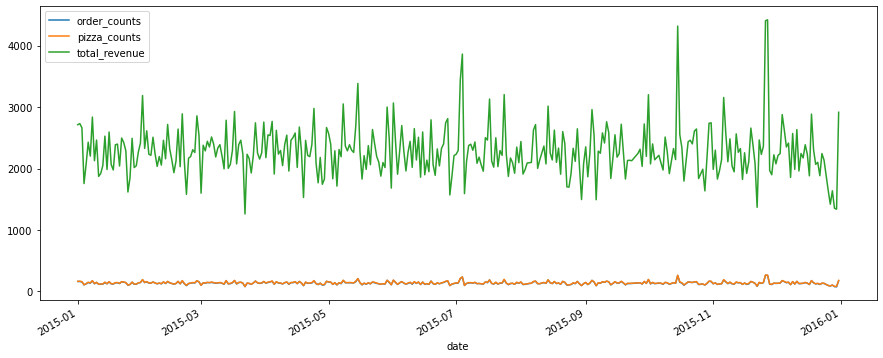

In [230]:
daily_sales.plot(figsize=(15,6));

In [231]:
(daily_sales['pizza_counts']-daily_sales['order_counts']).value_counts()

2    80
1    71
3    69
4    54
0    34
5    20
6    17
7     8
8     3
9     2
dtype: int64

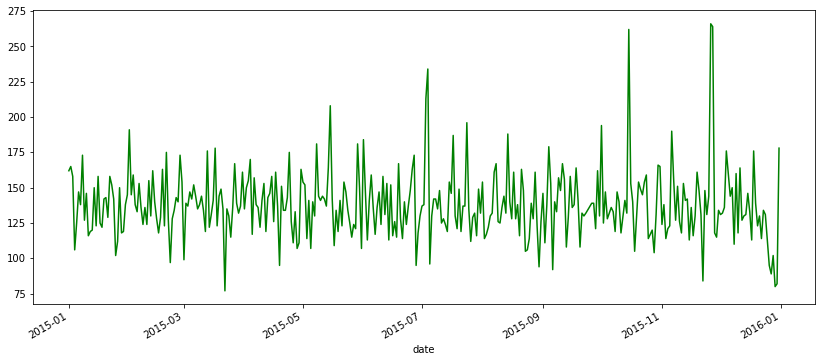

In [232]:
daily_sales['pizza_counts'].plot(figsize=(14,6), color='green');

In [233]:
daily_sales.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 358 entries, 2015-01-01 to 2015-12-31
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   order_counts   358 non-null    int64  
 1   pizza_counts   358 non-null    int64  
 2   total_revenue  358 non-null    float64
dtypes: float64(1), int64(2)
memory usage: 11.2 KB


In [234]:
idx = pd.date_range(daily_sales.index.min(), daily_sales.index.max())
print('missing_dates are',idx.difference(daily_sales.index))

missing_dates are DatetimeIndex(['2015-09-24', '2015-09-25', '2015-10-05', '2015-10-12',
               '2015-10-19', '2015-10-26', '2015-12-25'],
              dtype='datetime64[ns]', freq=None)


In [235]:
# Create rows for days with no sales (pizza place closed) as 0
daily_sales = daily_sales.reindex(idx, fill_value=np.nan)

In [236]:
daily_sales.describe()

,order_counts,pizza_counts,total_revenue
count,358.000000,358.000000,358.000000
mean,135.731844,138.396648,2281.713547
std,24.070523,24.438666,406.137497
min,73.000000,77.000000,1259.250000
25%,122.000000,124.000000,2047.875000
50%,133.000000,136.000000,2244.725000
75%,146.000000,150.000000,2463.237500
max,261.000000,266.000000,4422.450000


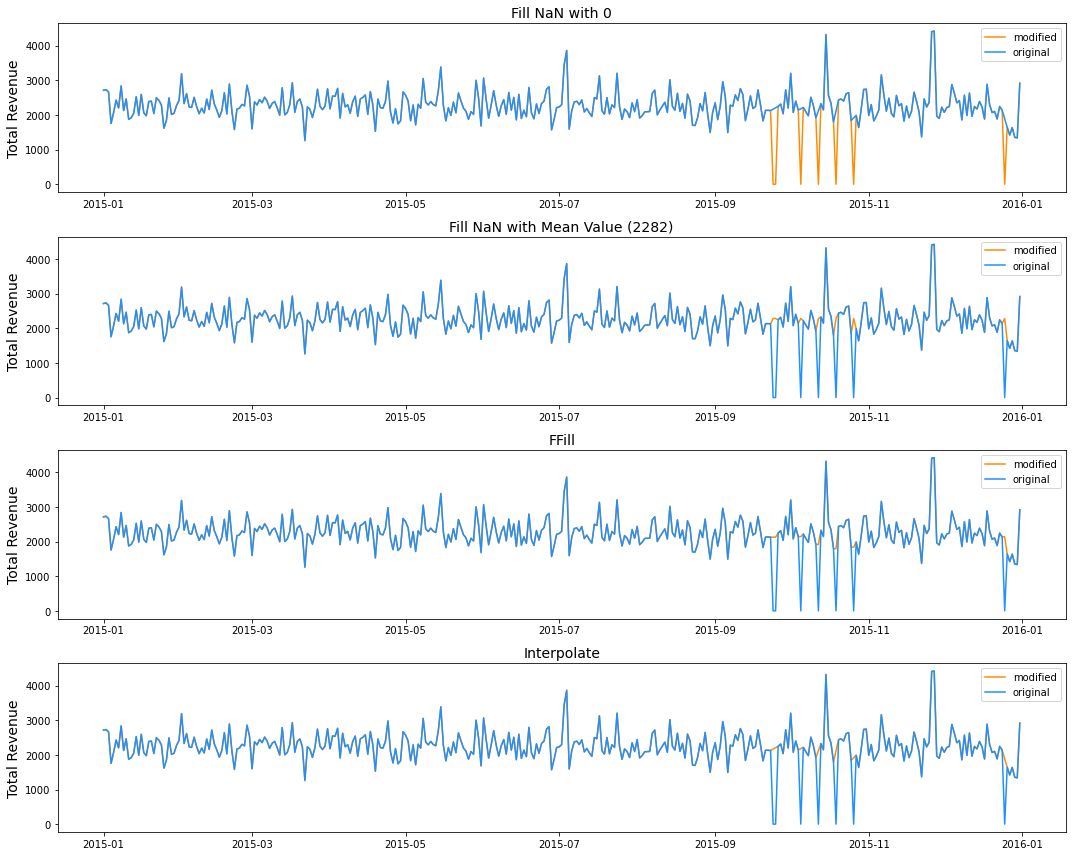

In [237]:
f, ax = plt.subplots(nrows=4, ncols=1, figsize=(15, 12))

sns.lineplot(x=daily_sales.index, y=daily_sales['total_revenue'].fillna(0), ax=ax[0], color='darkorange', label = 'modified')
sns.lineplot(x=daily_sales.index, y=daily_sales['total_revenue'].fillna(np.inf), ax=ax[0], color='dodgerblue', label = 'original')
ax[0].set_title('Fill NaN with 0', fontsize=14)
ax[0].set_ylabel(ylabel='Total Revenue', fontsize=14)

mean_drainage = daily_sales['total_revenue'].mean()
sns.lineplot(x=daily_sales.index, y=daily_sales['total_revenue'].fillna(mean_drainage), ax=ax[1], color='darkorange', label = 'modified')
sns.lineplot(x=daily_sales.index, y=daily_sales['total_revenue'].fillna(0), ax=ax[1], color='dodgerblue', label = 'original')
ax[1].set_title(f'Fill NaN with Mean Value ({mean_drainage:.0f})', fontsize=14)
ax[1].set_ylabel(ylabel='Total Revenue', fontsize=14)

sns.lineplot(x=daily_sales.index, y=daily_sales['total_revenue'].ffill(), ax=ax[2], color='darkorange', label = 'modified')
sns.lineplot(x=daily_sales.index, y=daily_sales['total_revenue'].fillna(0), ax=ax[2], color='dodgerblue', label = 'original')
ax[2].set_title(f'FFill', fontsize=14)
ax[2].set_ylabel(ylabel='Total Revenue', fontsize=14)

sns.lineplot(x=daily_sales.index, y=daily_sales['total_revenue'].interpolate(), ax=ax[3], color='darkorange', label = 'modified')
sns.lineplot(x=daily_sales.index, y=daily_sales['total_revenue'].fillna(0), ax=ax[3], color='dodgerblue', label = 'original')
ax[3].set_title(f'Interpolate', fontsize=14)
ax[3].set_ylabel(ylabel='Total Revenue', fontsize=14)

#for i in range(4):
 #   ax[i].set_xlim([date(2019, 5, 1), date(2019, 10, 1)])
    
plt.tight_layout()
plt.show()

In [238]:
daily_sales = daily_sales.interpolate()

In [239]:
daily_sales.shape

(365, 3)

<AxesSubplot:xlabel='order_counts', ylabel='Count'>

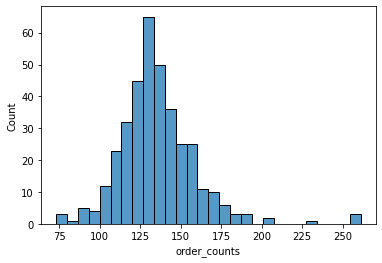

In [240]:
sns.histplot(data=daily_sales['order_counts'])

<AxesSubplot:xlabel='total_revenue', ylabel='Count'>

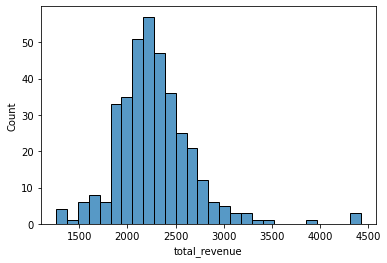

In [241]:
sns.histplot(data=daily_sales['total_revenue'])

<AxesSubplot:xlabel='pizza_counts', ylabel='Count'>

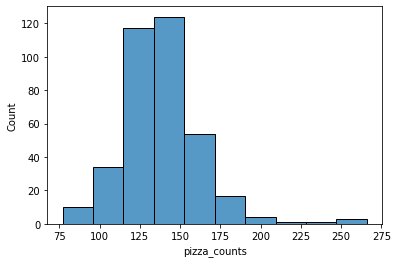

In [242]:
sns.histplot(data=daily_sales['pizza_counts'], bins=10)

In [243]:
x = daily_sales.reset_index()

In [244]:
x.rename(columns={'index':'date'}, inplace=True)

In [245]:
x['day'] = x.date.dt.day_name()
x['month'] = x.date.dt.month_name()

In [246]:
x.head()

,date,order_counts,pizza_counts,total_revenue,day,month
0,2015-01-01,161.0,162.0,2713.85,Thursday,January
1,2015-01-02,160.0,165.0,2731.90,Friday,January
2,2015-01-03,154.0,158.0,2662.40,Saturday,January
3,2015-01-04,106.0,106.0,1755.45,Sunday,January
4,2015-01-05,121.0,125.0,2065.95,Monday,January


In [247]:
x[['order_counts', 'pizza_counts', 'total_revenue']].mean()

order_counts      135.520548
pizza_counts      138.186301
total_revenue    2277.937123
dtype: float64

In [248]:
aggregates = x[['order_counts', 'pizza_counts', 'total_revenue', 'day', 'month']].groupby(['day','month']).agg(['min', 'max', 'mean', 'median'])

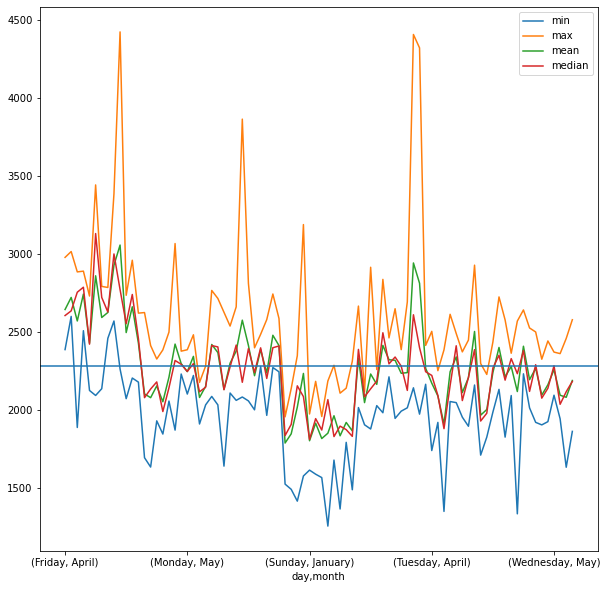

In [249]:
aggregates['total_revenue'].plot(figsize=(10,10))
plt.axhline(y=2281.7)

<AxesSubplot:xlabel='day,month'>

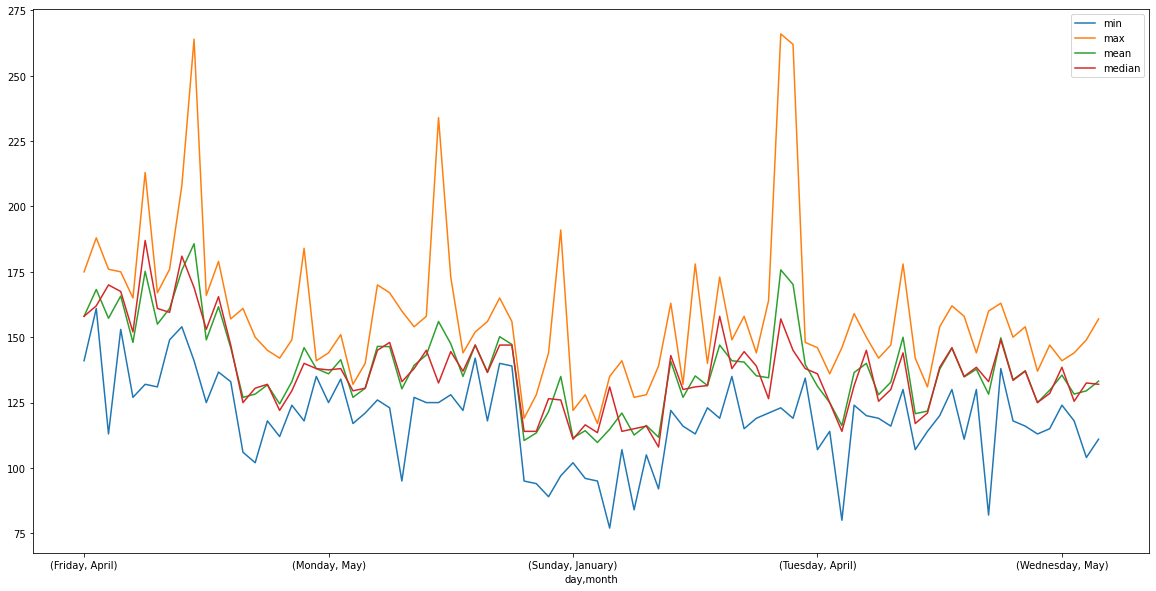

In [171]:
aggregates['pizza_counts'].plot(figsize=(20,10))

<AxesSubplot:xlabel='day,month'>

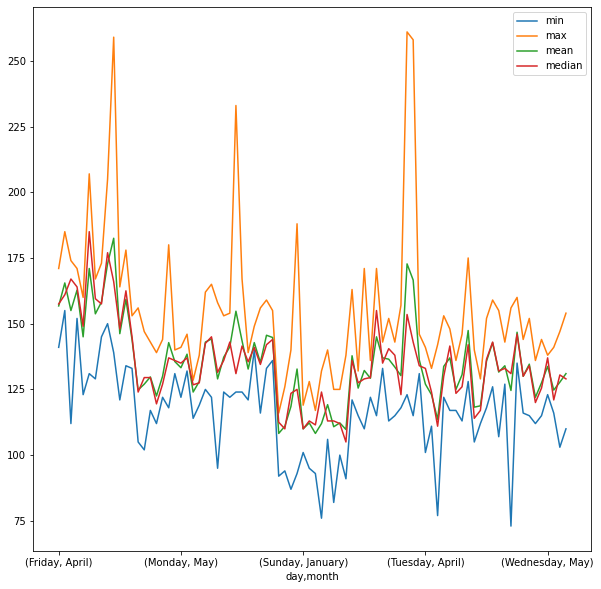

In [172]:
aggregates['order_counts'].plot(figsize=(10,10))

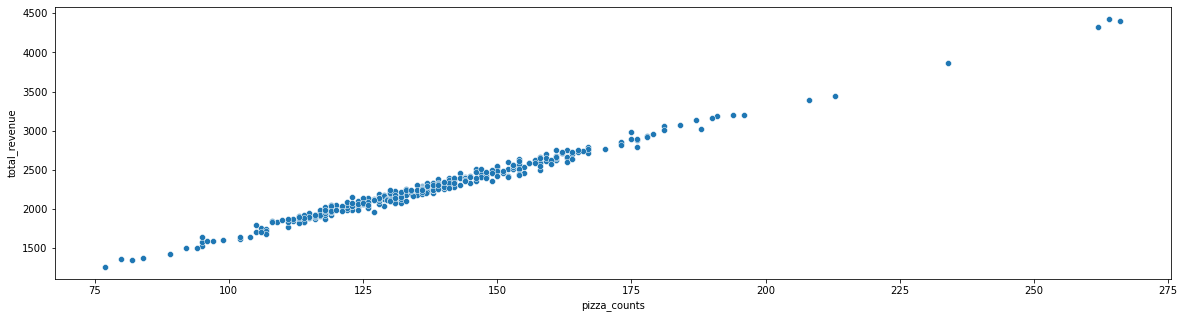

In [250]:
plt.figure(figsize=(20,5))
sns.scatterplot(data=x, x='pizza_counts', y='total_revenue');

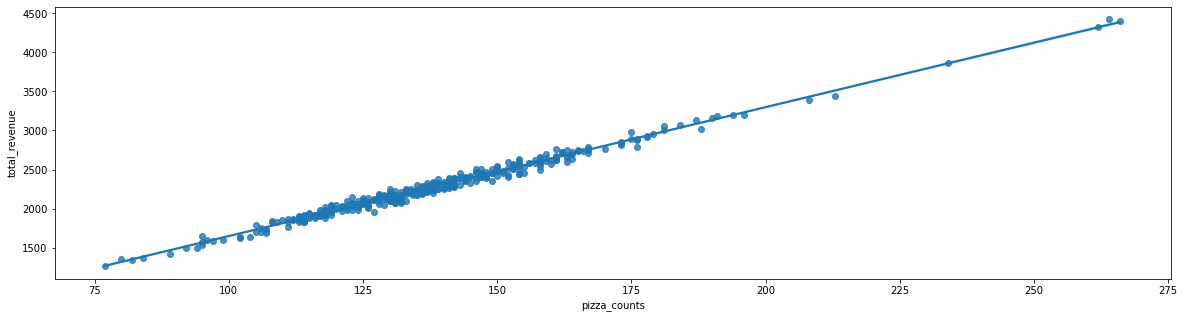

In [251]:
plt.figure(figsize=(20,5))
sns.regplot(data=x, x='pizza_counts', y='total_revenue');

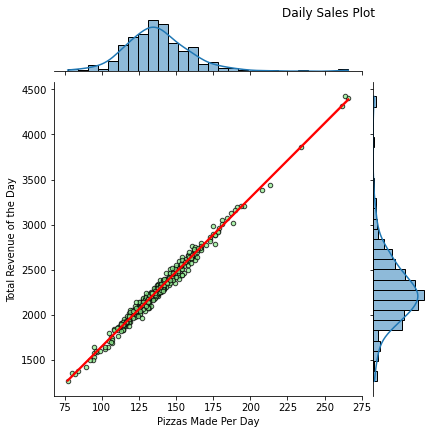

In [252]:
g = sns.jointplot(data=x, x='pizza_counts', y='total_revenue', kind='reg',
                   joint_kws= {'line_kws': {'color':'red'}, 'color':'lightgreen'},
                   scatter_kws= {'s':20, 'alpha':0.75, 'edgecolor':'black'})
g.ax_joint.set_xlabel('Pizzas Made Per Day')
g.ax_joint.set_ylabel('Total Revenue of the Day')
g.fig.suptitle('Daily Sales Plot', x=0.75,y=1);

In [253]:
weekly_sales = daily_sales

In [254]:
weekly_sales['week'] = weekly_sales.index.week

C:\Users\ADMIN\AppData\Local\Temp/ipykernel_17068/2266821961.py:1: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  weekly_sales['week'] = weekly_sales.index.week


In [255]:
weekly_sales.reset_index(inplace=True)

In [256]:
weekly_sales = weekly_sales[['order_counts', 'pizza_counts','total_revenue','week']].groupby('week').agg('sum')

In [257]:
weekly_sales

,order_counts,pizza_counts,total_revenue
week,,,
1,581.0,591.0,9863.600
2,951.0,972.0,15999.050
3,898.0,917.0,15115.950
4,952.0,968.0,15652.800
5,960.0,973.0,16279.200
6,972.0,988.0,16175.700
7,959.0,975.0,16049.600
8,913.0,932.0,15309.950
9,956.0,971.0,15925.850


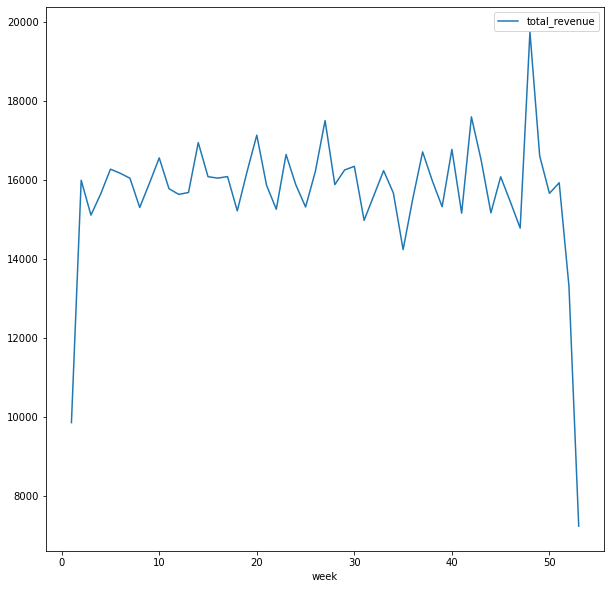

In [258]:
weekly_sales.plot(y='total_revenue', figsize=(10,10));

In [259]:
from statsmodels.tsa.stattools import adfuller

In [260]:
# Reference https://www.analyticsvidhya.com/blog/2020/10/how-to-create-an-arima-model-for-time-series-forecasting-in-python/
# Null hypothesis is Data is non-stationary.
def run_adfuller_test(data):
    result = adfuller(data)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis(Ho). We reject the null hypothesis. Data is stationary")
    else:
        print("Weak evidence against null hypothesis. We cannot reject the null hypothesis. Data is non-stationary ")

In [261]:
run_adfuller_test(weekly_sales['total_revenue'])

ADF Test Statistic : -3.508969398788586
p-value : 0.007759706832620521
#Lags Used : 5
Number of Observations : 47
Strong evidence against the null hypothesis(Ho). We reject the null hypothesis. Data is stationary


In [262]:
run_adfuller_test(weekly_sales['pizza_counts'])

ADF Test Statistic : -2.6501690296005807
p-value : 0.08306518591618323
#Lags Used : 6
Number of Observations : 46
Weak evidence against null hypothesis. We cannot reject the null hypothesis. Data is non-stationary 


In [263]:
run_adfuller_test(daily_sales['total_revenue'])

ADF Test Statistic : -5.256264651873544
p-value : 6.741355649477949e-06
#Lags Used : 15
Number of Observations : 349
Strong evidence against the null hypothesis(Ho). We reject the null hypothesis. Data is stationary


In [264]:
run_adfuller_test(daily_sales['pizza_counts'])

ADF Test Statistic : -5.1472813727615145
p-value : 1.1253731314268417e-05
#Lags Used : 15
Number of Observations : 349
Strong evidence against the null hypothesis(Ho). We reject the null hypothesis. Data is stationary


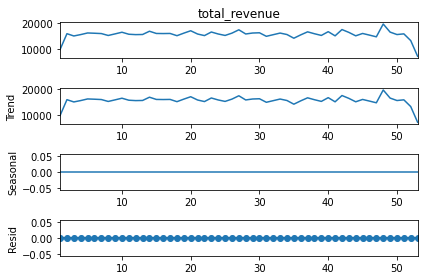

In [265]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomp=seasonal_decompose(weekly_sales['total_revenue'], period=1)
decomp.plot()
plt.rcParams.update({'figure.figsize': (10,5)})
plt.show()

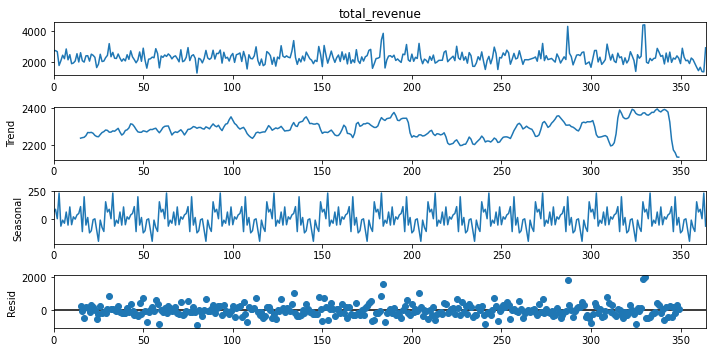

In [266]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomp=seasonal_decompose(daily_sales['total_revenue'], period=30)
decomp.plot()
plt.rcParams.update({'figure.figsize': (10,5)})
plt.show()

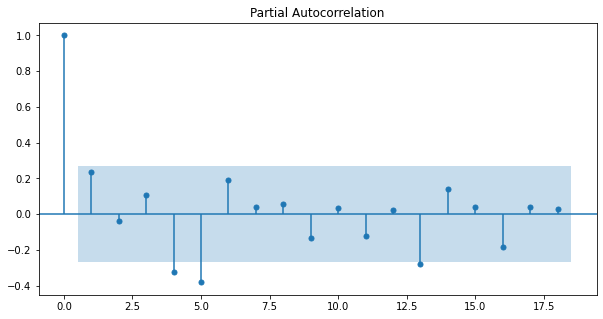

In [267]:
from statsmodels.graphics.tsaplots import plot_pacf
pacf =  plot_pacf(weekly_sales['total_revenue'].values.squeeze(), method='ols')

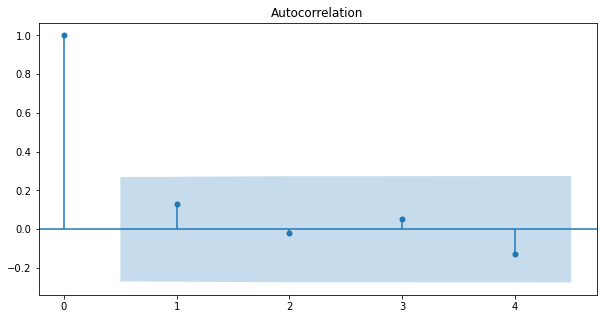

In [268]:
from statsmodels.graphics.tsaplots import plot_acf
acf =  plot_acf(weekly_sales['total_revenue'].values.squeeze(), lags=4)

In [269]:
daily_sales.rename(columns={'index':'date'}, inplace=True)

In [270]:
df = daily_sales.drop(columns=['week'])

In [271]:
df.head()

,date,order_counts,pizza_counts,total_revenue
0,2015-01-01,161.0,162.0,2713.85
1,2015-01-02,160.0,165.0,2731.90
2,2015-01-03,154.0,158.0,2662.40
3,2015-01-04,106.0,106.0,1755.45
4,2015-01-05,121.0,125.0,2065.95


In [272]:
downsample = df[['date',
                 'order_counts', 
                 'pizza_counts',
                 'total_revenue', 
                 ]].resample('7D', on='date').sum().reset_index(drop=False)

df = downsample.copy()

In [196]:
df.head()

,date,order_counts,pizza_counts,total_revenue
0,2015-01-01,979.0,1001.0,16560.70
1,2015-01-08,932.0,951.0,15798.00
2,2015-01-15,924.0,942.0,15445.50
3,2015-01-22,923.0,934.0,15183.75
4,2015-01-29,1015.0,1035.0,17099.95


In [273]:
# q = 3, p = 1, d=0
from statsmodels.tsa.arima.model import ARIMA
# For ARIMA - set p = 1, d = 0 and set q = 3 (from PACF plot)
arimaModel = ARIMA(df['total_revenue'], order=(1, 0, 3))
arima_fit=arimaModel.fit()
arima_fit.summary()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:          total_revenue   No. Observations:                   53
Model:                 ARIMA(1, 0, 3)   Log Likelihood                -472.830
Date:                Tue, 10 Jan 2023   AIC                            957.659
Time:                        12:13:33   BIC                            969.481
Sample:                             0   HQIC                           962.205
                                 - 53                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.569e+04    769.716     20.382      0.000    1.42e+04    1.72e+04
ar.L1          0.8794      0.518      1.699      0.089      -0.135       1.894
ma.L1         -0.1164      0.463     -0.251      0.801      -1.023       0.791
ma.L2         -0.5477      0.240     -2.287      0.022      -1.017      -0.078
ma.L3         -0.3356      0.337     -0.996      0.319      -0.996       0.325
sigma2      3.155e+06      0.003    1.1e+09      0.000    3.15e+06    3.15e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               285.57
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):              10.46   Skew:                            -2.35
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.36
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 9.1e+26. Standard errors may be unstable.
"""

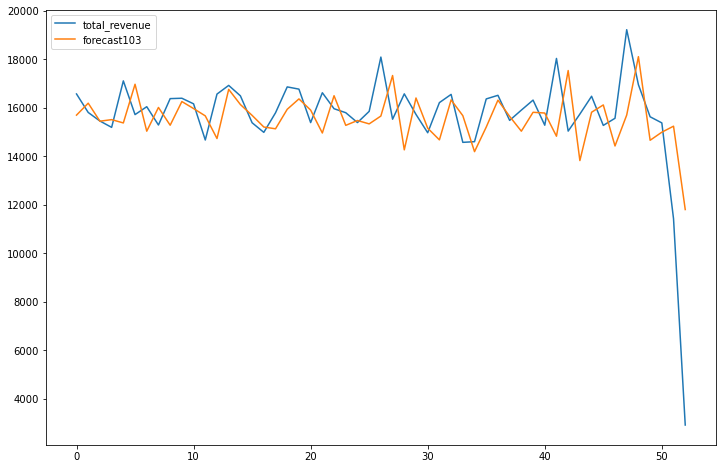

In [198]:
df['forecast103']=arima_fit.predict(start=0,end=54)
df[['total_revenue','forecast103']].plot(figsize=(12,8));

In [199]:
# q = 3, p = 1, d=0
from statsmodels.tsa.arima.model import ARIMA
# For ARIMA - set p = 1, d = 0 and set q = 3 (from PACF plot)
arimaModel = ARIMA(df['total_revenue'][:44], order=(2, 0, 3))
arima_fit=arimaModel.fit()
arima_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:          total_revenue   No. Observations:                   44
Model:                 ARIMA(2, 0, 3)   Log Likelihood                -349.425
Date:                Tue, 10 Jan 2023   AIC                            712.851
Time:                        12:05:07   BIC                            725.340
Sample:                             0   HQIC                           717.482
                                 - 44                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.597e+04     94.643    168.741      0.000    1.58e+04    1.62e+04
ar.L1          0.3496      0.090      3.886      0.000       0.173       0.526
ar.L2         -0.9923      0.075    -13.222      0.000      -1.139      -0.845
ma.L1         -0.6891      0.294     -2.341      0.019      -1.266      -0.112
ma.L2          1.0657      0.443      2.408      0.016       0.198       1.933
ma.L3         -0.3746      0.332     -1.127      0.260      -1.026       0.277
sigma2      5.848e+05   2.47e+05      2.372      0.018    1.02e+05    1.07e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 2.53
Prob(Q):                              0.96   Prob(JB):                         0.28
Heteroskedasticity (H):               2.36   Skew:                             0.50
Prob(H) (two-sided):                  0.11   Kurtosis:                         3.61
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

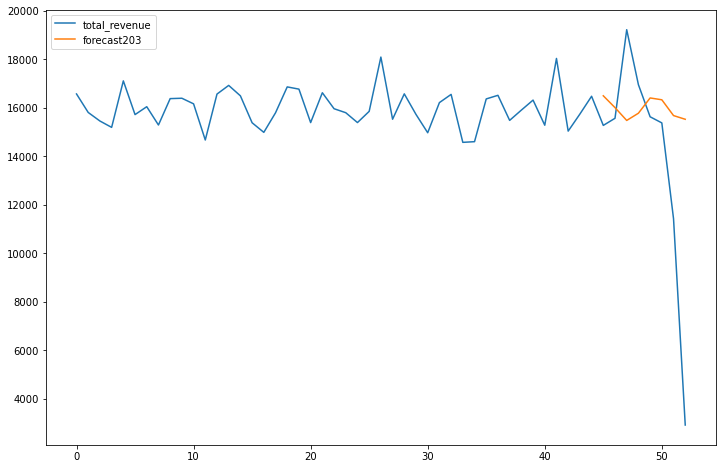

In [200]:
df['forecast203']=arima_fit.predict(start=45,end=54)
df[['total_revenue','forecast203']].plot(figsize=(12,8));

In [277]:
# q = 3, p = 1, d=0
from statsmodels.tsa.arima.model import ARIMA
# For ARIMA - set p = 1, d = 0 and set q = 3 (from PACF plot)
arimaModel = ARIMA(df['total_revenue'], order=(2, 0, 1))
arima_fit=arimaModel.fit()
arima_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:          total_revenue   No. Observations:                   53
Model:                 ARIMA(2, 0, 1)   Log Likelihood                -472.608
Date:                Tue, 10 Jan 2023   AIC                            955.217
Time:                        12:15:07   BIC                            965.068
Sample:                             0   HQIC                           959.005
                                 - 53                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.568e+04    923.882     16.976      0.000    1.39e+04    1.75e+04
ar.L1          1.5928      0.952      1.672      0.094      -0.274       3.459
ar.L2         -0.7717      0.572     -1.349      0.177      -1.893       0.349
ma.L1         -0.7993      0.985     -0.812      0.417      -2.730       1.131
sigma2      3.169e+06   7.06e+05      4.489      0.000    1.79e+06    4.55e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               299.20
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):               9.36   Skew:                            -2.33
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.66
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

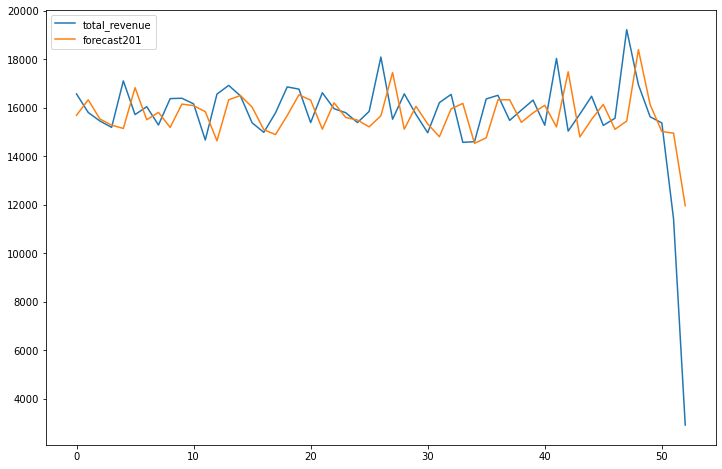

In [278]:
df['forecast201']=arima_fit.predict(start=0,end=54)
df[['total_revenue','forecast201']].plot(figsize=(12,8));

In [276]:
df.head()

,date,order_counts,pizza_counts,total_revenue
0,2015-01-01,979.0,1001.0,16560.70
1,2015-01-08,932.0,951.0,15798.00
2,2015-01-15,924.0,942.0,15445.50
3,2015-01-22,923.0,934.0,15183.75
4,2015-01-29,1015.0,1035.0,17099.95


In [204]:
# q = 3, p = 1, d=0
from statsmodels.tsa.arima.model import ARIMA
# For ARIMA - set p = 1, d = 0 and set q = 3 (from PACF plot)
arimaModel = ARIMA(df['total_revenue'], order=(2, 1, 1))
arima_fit=arimaModel.fit()
arima_fit.summary()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:          total_revenue   No. Observations:                   53
Model:                 ARIMA(2, 1, 1)   Log Likelihood                -464.200
Date:                Tue, 10 Jan 2023   AIC                            936.400
Time:                        12:05:07   BIC                            944.205
Sample:                             0   HQIC                           939.392
                                 - 53                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2155      2.613     -0.082      0.934      -5.337       4.906
ar.L2         -0.0740      0.294     -0.252      0.801      -0.650       0.502
ma.L1          0.1688      2.655      0.064      0.949      -5.034       5.372
sigma2      3.343e+06   6.19e+05      5.404      0.000    2.13e+06    4.56e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               151.27
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               8.30   Skew:                            -1.85
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.49
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

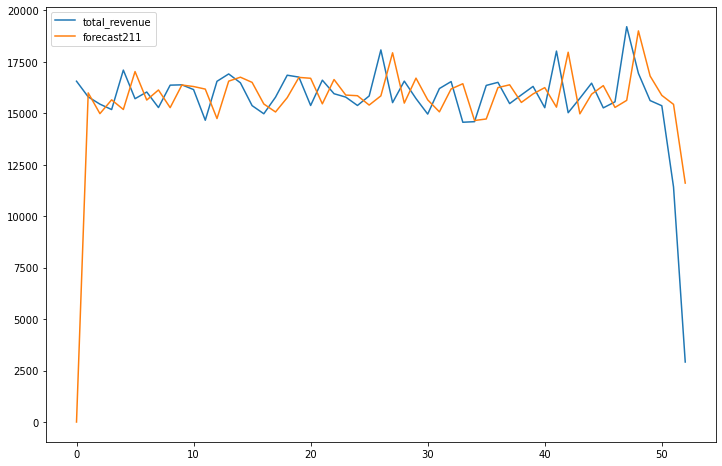

In [205]:
df['forecast211']=arima_fit.predict(start=0,end=54)
df[['total_revenue','forecast211']].plot(figsize=(12,8));

In [206]:
# q = 3, p = 1, d=0
from statsmodels.tsa.arima.model import ARIMA
# For ARIMA - set p = 1, d = 0 and set q = 3 (from PACF plot)
arimaModel = ARIMA(df['total_revenue'], order=(1, 1, 3))
arima_fit=arimaModel.fit()
arima_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:          total_revenue   No. Observations:                   53
Model:                 ARIMA(1, 1, 3)   Log Likelihood                -463.205
Date:                Tue, 10 Jan 2023   AIC                            936.409
Time:                        12:05:08   BIC                            946.165
Sample:                             0   HQIC                           940.149
                                 - 53                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8973      0.260     -3.458      0.001      -1.406      -0.389
ma.L1          0.9149      0.278      3.292      0.001       0.370       1.460
ma.L2         -0.0827      0.287     -0.288      0.773      -0.645       0.479
ma.L3         -0.1611      0.210     -0.767      0.443      -0.573       0.251
sigma2      3.183e+06   5.53e+05      5.760      0.000     2.1e+06    4.27e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               106.11
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):              13.45   Skew:                            -1.74
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.07
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

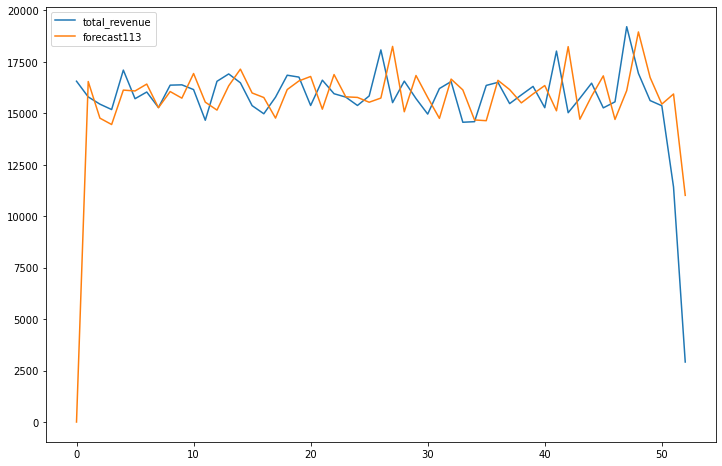

In [207]:
df['forecast113']=arima_fit.predict(start=0,end=54)
df[['total_revenue','forecast113']].plot(figsize=(12,8));

In [208]:
df.head()

,date,order_counts,pizza_counts,total_revenue,forecast103,forecast203,forecast201,forecast211,forecast113
0,2015-01-01,979.0,1001.0,16560.70,15688.439063,NaN,15683.578913,0.000000,0.000000
1,2015-01-08,932.0,951.0,15798.00,16180.397191,NaN,16319.931059,15992.753261,16545.157364
2,2015-01-15,924.0,942.0,15445.50,15438.227802,NaN,15527.602692,14984.736058,14764.800962
3,2015-01-22,923.0,934.0,15183.75,15502.683028,NaN,15274.657606,15655.574962,14456.024571
4,2015-01-29,1015.0,1035.0,17099.95,15366.326920,NaN,15139.210585,15186.596560,16128.325645


In [209]:
# q = 3, p = 1, d=0
from statsmodels.tsa.arima.model import ARIMA
# For ARIMA - set p = 1, d = 0 and set q = 3 (from PACF plot)
arimaModel = ARIMA(df['total_revenue'], order=(1, 0, 1))
arima_fit=arimaModel.fit()
arima_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:          total_revenue   No. Observations:                   53
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -473.112
Date:                Tue, 10 Jan 2023   AIC                            954.224
Time:                        12:05:08   BIC                            962.105
Sample:                             0   HQIC                           957.254
                                 - 53                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.566e+04   1083.129     14.461      0.000    1.35e+04    1.78e+04
ar.L1          0.6152      0.553      1.112      0.266      -0.470       1.700
ma.L1          0.2437      0.514      0.474      0.636      -0.765       1.252
sigma2      3.244e+06   6.66e+05      4.868      0.000    1.94e+06    4.55e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               264.20
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               9.70   Skew:                            -2.27
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.95
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

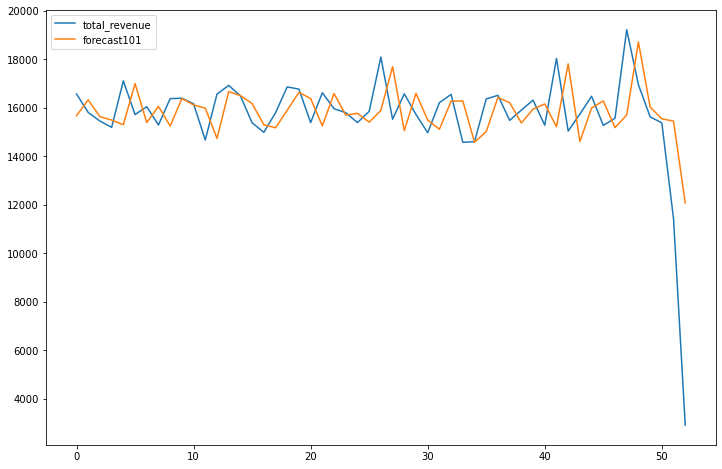

In [210]:
df['forecast101']=arima_fit.predict(start=0,end=54)
df[['total_revenue','forecast101']].plot(figsize=(12,8));

In [211]:
# q = 3, p = 1, d=0
from statsmodels.tsa.arima.model import ARIMA
# For ARIMA - set p = 1, d = 0 and set q = 3 (from PACF plot)
arimaModel = ARIMA(df['total_revenue'], order=(1, 1, 1))
arima_fit=arimaModel.fit()
arima_fit.summary()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:          total_revenue   No. Observations:                   53
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -464.354
Date:                Tue, 10 Jan 2023   AIC                            934.708
Time:                        12:05:08   BIC                            940.561
Sample:                             0   HQIC                           936.952
                                 - 53                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1874      6.636      0.028      0.977     -12.819      13.194
ma.L1         -0.2315      6.654     -0.035      0.972     -13.274      12.811
sigma2      3.347e+06   6.84e+05      4.891      0.000    2.01e+06    4.69e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               144.47
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):               8.59   Skew:                            -1.80
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.33
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

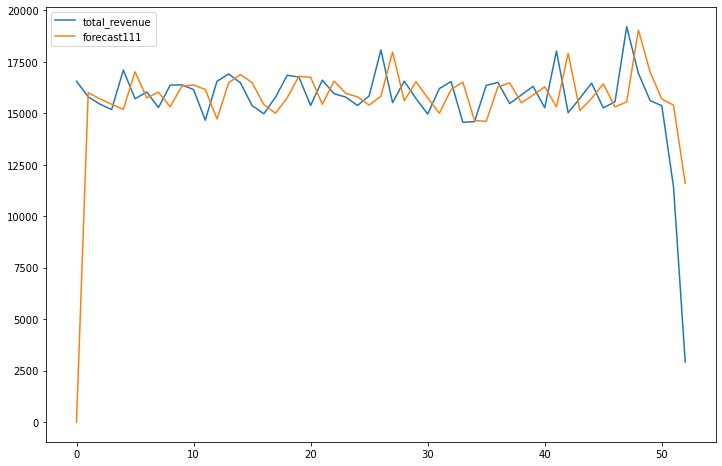

In [212]:
df['forecast111']=arima_fit.predict(start=0,end=54)
df[['total_revenue','forecast111']].plot(figsize=(12,8));

In [213]:
df.head()

,date,order_counts,pizza_counts,total_revenue,forecast103,forecast203,forecast201,forecast211,forecast113,forecast101,forecast111
0,2015-01-01,979.0,1001.0,16560.70,15688.439063,NaN,15683.578913,0.000000,0.000000,15662.587475,0.000000
1,2015-01-08,932.0,951.0,15798.00,16180.397191,NaN,16319.931059,15992.753261,16545.157364,16315.171764,16003.555405
2,2015-01-15,924.0,942.0,15445.50,15438.227802,NaN,15527.602692,14984.736058,14764.800962,15623.783616,15702.653644
3,2015-01-22,923.0,934.0,15183.75,15502.683028,NaN,15274.657606,15655.574962,14456.024571,15485.671944,15438.983799
4,2015-01-29,1015.0,1035.0,17099.95,15366.326920,NaN,15139.210585,15186.596560,16128.325645,15294.446337,15193.795042


In [215]:
df['forecast103'] -= df['total_revenue']
df['forecast203'] -= df['total_revenue']
df['forecast201'] -= df['total_revenue']
df['forecast211'] -= df['total_revenue']
df['forecast113'] -= df['total_revenue']
df['forecast101'] -= df['total_revenue']
df['forecast111'] -= df['total_revenue']

In [216]:
square_errors = df[['forecast103','forecast203','forecast201','forecast211','forecast113','forecast101','forecast111']].apply(lambda x : x*x)

In [217]:
np.sqrt(square_errors.sum())

forecast103    13060.785688
forecast203    13979.632465
forecast201    12988.510844
forecast211    21141.360476
forecast113    20978.546590
forecast101    13179.478532
forecast111    21166.126282
dtype: float64

In [299]:
# The lowest error in ARIMA model is of parameters - 2,0,3  p = 2, d=0, q=3

In [ ]:
2,0,1